In [50]:
# PyTorch之数据加载和处理

# 下载安装相应的包
from __future__ import print_function, division
import os
import torch
import pandas as pd              #用于更容易地进行csv解析
from skimage import io, transform    #用于图像的IO和变换
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode，打开交互模式， 对应的plt.ioff()关闭交互模式

In [51]:
# 下载数据集
# 从此处下载数据集，数据存于“data/faces/”的目录中。这个数据集实际上是imagenet数据集标注为face的图片当中
# 在dlib 面部检测 (dlib’s pose estimation) 表现良好的图片。

# 数据集注释
# 数据集是按如下规则打包成的csv文件:
# image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
# 0805personali01.jpg,27,83,27,98, ... 84,134
# 1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312


In [52]:
# 读取数据集
# 将csv中的标注点数据读入（N，2）数组中，其中N是特征点的数量。读取数据代码如下：
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv') # landmarks_frame类型是pandas.core.frame.DataFrame

n = 65 # csv第一行是各列的说明，这里的65表示实际数据的第66行(从0开始)，即原始文件的第67行
img_name = landmarks_frame.iloc[n, 0] # iloc通过索引值来访问数据
# 或者np.array([landmarks_frame.iloc[n, 1:]]) 也行
# landmarks_ = landmarks_frame.iloc[n, 1:].as_matrix() 
# landmarks_frame.iloc[n, 1:]类型是pandas.core.series.Series，转为np.array，先用[]将其转为list，然后再用np.array转为合适类型
landmarks_ = np.array([landmarks_frame.iloc[n, 1:]]) 
landmarks = landmarks_.astype('float').reshape(-1, 2) # 将第2维固定为2，第1维自动计算,例如[1,2,3,4]reshape后变为[[1. 2.],[3. 4.]]

print('Total landmarks: {}'.format(len(landmarks_frame)))
print('type: {}'.format(type(landmarks_frame)))
print('Image name: {}'.format(img_name))
print('landmarks_frame.iloc[n, 1:] type:', type(landmarks_frame.iloc[n, 1:]))
print('[landmarks_frame.iloc[n, 1:]] type: {}'.format(type([landmarks_frame.iloc[n, 1:]])))
print('landmarks_ type: {}'.format(type(landmarks_)))
print('landmarks_ shape: {}'.format(landmarks_.shape)) # 输出： (136,)
print('Landmarks shape: {}'.format(landmarks.shape))  # 输出：(68, 2)
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Total landmarks: 69
type: <class 'pandas.core.frame.DataFrame'>
Image name: person-7.jpg
landmarks_frame.iloc[n, 1:] type: <class 'pandas.core.series.Series'>
[landmarks_frame.iloc[n, 1:]] type: <class 'list'>
landmarks_ type: <class 'numpy.ndarray'>
landmarks_ shape: (1, 136)
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


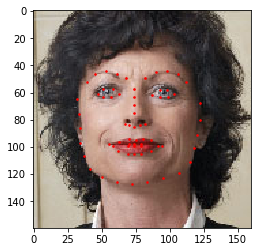

In [53]:
# 写一个简单的函数来展示一张图片和它对应的标注点作为例子。
def show_landmarks(image, landmarks):
    """显示带有地标的图片"""
    plt.imshow(image)
    # 头两个参数是绘制的数据点集，分布对应x和y的，这俩要个数一样。s是点的大小，marker是点的样子，c是颜色
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)
plt.show()

In [54]:
# 数据集类
# torch.utils.data.Dataset是表示数据集的抽象类，因此自定义数据集应继承Dataset并覆盖以下方法
# *__len__ 实现len(dataset)返还数据集的尺寸
# *__getitem__用来获取一些索引数据，例如dataset[i]中的(i)

# 建立数据集
# 为面部数据集创建一个数据集类。我们将在 __init__中读取csv的文件内容，
# 在 __getitem__中读取图片。这么做是为了节省内存空间。只有在需要用到图片的时候才读取它而不是一开始就把图片全部存进内存里。

# 我们的数据样本将按这样一个字典{'image': image, 'landmarks': landmarks}组织。
# 我们的数据集类将添加一个可选参数transform以方便对样本进行预处理。
# 下一节我们会看到什么时候需要用到transform参数。 

# __init__方法如下图所示：
# 自己的Dataset继承torch.utils.data.Dataset
class FaceLandmarksDataset(Dataset):
    """面部标记数据集."""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        csv_file（string）：带注释的csv文件的路径。
        root_dir（string）：包含所有图像的目录。
        transform（callable， optional）：一个样本上的可用的可选变换
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name) 
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks, 'name': self.landmarks_frame.iloc[idx, 0]} # 这才是单独的一条数据，image是原始图像，landmarks是标注点

        if self.transform:
            sample = self.transform(sample)

        return sample


0 0805personali01.jpg (324, 215, 3) (68, 2)


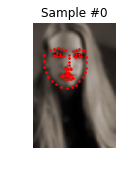

1 1084239450_e76e00b7e7.jpg (500, 333, 3) (68, 2)


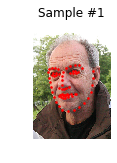

2 10comm-decarlo.jpg (250, 258, 3) (68, 2)


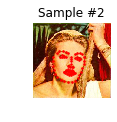

3 110276240_bec305da91.jpg (434, 290, 3) (68, 2)


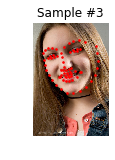

In [56]:
# 数据可视化
# 实例化这个类并遍历数据样本。我们将会打印出前四个例子的尺寸并展示标注的特征点
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv', root_dir='data/faces/')
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['name'], sample['image'].shape, sample['landmarks'].shape)
    sample.pop('name') #否则show_landmarks(**sample) 这句要报错！key和函数的参数名，必须精确匹配，多一个少一个都不行

    ax = plt.subplot(1, 4, i + 1) #讲道理应该是1行4列展示，为毛是4行1列？？？？
    #ax = plt.subplot(1, 1, 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    #ax.axis('on')
    #print(sample)
    show_landmarks(**sample) #liujia: 这个用法有点怪啊，因为show_landmarks()函数的两个参数分别叫image, landmarks，而sample是dict，里面的key也是这两个名字，所以才能这样吧。。。。。

    if i == 3:
        plt.show()
        break


In [57]:
# 数据变换
# 通过上面的例子我们会发现图片并不是同样的尺寸。绝大多数神经网络都假定图片的尺寸相同。因此我们需要做一些预处理。
# 让我们创建三个转换: 
# * Rescale：缩放图片 
# * RandomCrop：对图片进行随机裁剪。这是一种数据增强操作 
# * ToTensor：把numpy格式图片转为torch格式图片 (我们需要交换坐标轴).

# 注意torchvision.transforms里有一堆定义好的transform
# 我们会把它们写成可调用的类的形式而不是简单的函数，这样就不需要每次调用时传递一遍参数。
# 我们只需要实现__call__方法，必要的时候实现 __init__方法
# 我们可以这样调用这些转换:
# tsfm = Transform(params)
# transformed_sample = tsfm(sample)

# 下面是自定义的transform, 观察下面这些转换是如何应用在图像和标签上的
class Rescale(object):
    """将样本中的图像重新缩放到给定大小。.
    
    Args:
        output_size（tuple或int）：所需的输出大小。 如果是元组，则输出为
         与output_size匹配。 如果是int，则匹配较小的图像边缘到output_size保持纵横比相同。
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) #我擦，还能这样。。。。 isinstance两个类型中的一个
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2] #image.shape[:2]返回前两个元素的[]，并且和()元组一样，可以赋值给两个变量
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w)) #调用torch自带的resize

        # h and w are swapped for landmarks because for images, x and y axes are axis 1 and 0 respectively
        # 对标记点要进行相应的坐标调整，并且h/w要互换，image的是h/w即高和宽, landmark要x/y即宽和高，所以要互换到同一个表示
        landmarks = landmarks * [new_w / w, new_h / h] 

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """随机裁剪样本中的图像.

    Args:
       output_size（tuple或int）：所需的输出大小。 如果是int，方形裁剪是。         
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,left: left + new_w]
        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """将样本中的ndarrays转换为Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # 交换颜色轴因为
        # numpy包的图片是: H * W * C
        # torch包的图片是: C * H * W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}


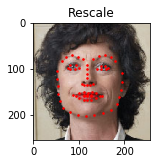

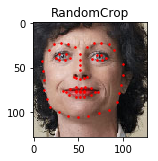

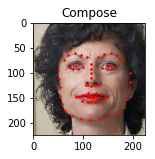

In [58]:
# 组合转换
# 接下来我们把这些转换应用到一个例子上。

# 我们想要把图像的短边调整为256，然后随机裁剪(randomcrop)为224大小的正方形。
# 也就是说，我们打算组合一个Rescale和 RandomCrop的变换。
# 我们可以调用一个简单的类 torchvision.transforms.Compose来实现这一操作。

scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)]) #Compose组合一些transform，共同应用到样本上

# 在样本上应用上述的每个变换。
fig = plt.figure() # 新建子图？
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    # 套路....
    ax = plt.subplot(1, 3, i + 1) # 1行3列, 但就是3行1列。。。。。
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
**************************************************
0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
batch size: 4
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
batch size: 4
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
batch size: 4
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
batch size: 4
images_batch size: torch.Size([4, 3, 224, 224])
grid size: torch.Size([3, 228, 906])


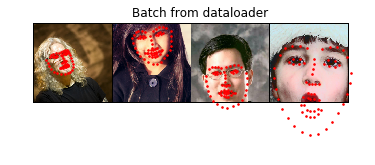

In [67]:
# 迭代数据集

# 让我们把这些整合起来以创建一个带组合转换的数据集。总结一下，每次这个数据集被采样时: 
# * 及时地从文件中读取图片 
# * 对读取的图片应用转换 
# * 由于其中一步操作是随机的 (randomcrop) , 数据被增强了 ----提高了模型的泛化能力

# 我们可以像之前那样使用for i in range循环来对所有创建的数据集执行同样的操作。
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

# 会打印出所有的sample信息，一共69条
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

print('*'*50)

# 但是，对所有数据集简单的使用for循环牺牲了许多功能，尤其是: 
# * 批量处理数据 
# * 打乱数据 
# * 使用多线程multiprocessingworker并行加载数据。

# torch.utils.data.DataLoader是一个提供上述所有这些功能的迭代器。下面使用的参数必须是清楚的。
# 一个值得关注的参数是collate_fn, 可以通过它来决定如何对数据进行批处理。但是绝大多数情况下默认值就能运行良好。

dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# 辅助功能：显示批次
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2) #size类似torch.Size([4, 3, 224, 224])，而且已经裁剪为正方形了，所以这样可以....
    grid_border_size = 2

    grid = utils.make_grid(images_batch) #将四张拼起来，从torch.Size([4, 3, 224, 224])变为torch.Size([3, 228, 906])，即在最后一维width拼起来
    print('images_batch size:', images_batch.size())
    print('grid size:', grid.size())
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')
        
#注意这里使用Dataloader加载数据，并且设置了batch_size为4，意味着每次加载4个样本  
#上面用普通的for循环一个一个加载样本，每个sample就是一个sample，比如其size是 torch.Size([3, 224, 224])
#而批量加载的话，每次是4个样本，即在返回的Tensor的第一维是batch，例如其size变为 torch.Size([4, 3, 224, 224])
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())
    print('batch size:', sample_batched['image'].size(0)) # size()[0] 和 size(0) 等价
    #print('batch size:', len(sample_batched['image'].size())) # size是个Tensor，len()返回其第一维的长度
    #print('sample_batched type:', type(sample_batched))
    #print('sample_batched len:', len(sample_batched))
    #print('sample_batched keys:', sample_batched.keys())

    # 观察第4批次并停止。
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [68]:
# 后记：torchvision
# 在这篇教程中我们学习了如何构造和使用数据集类(datasets),转换(transforms)和数据加载器(dataloader)。
# torchvision包提供了常用的数据集类(datasets)和转换(transforms)。你可能不需要自己构造这些类。

# torchvision中还有一个更常用的数据集类ImageFolder。
# 它假定了数据集是以如下方式构造的:
#root/ants/xxx.png
#root/ants/xxy.jpeg
#root/ants/xxz.png
#.
#.
#.
#root/bees/123.jpg
#root/bees/nsdf3.png
#root/bees/asd932_.png

# 其中'ants’,bees’等是分类标签。在PIL.Image中你也可以使用类似的转换(transforms)
# 例如RandomHorizontalFlip,Scale。利用这些你可以按如下的方式创建一个数据加载器(dataloader) :
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

#注意是ImageLoader!!!
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train', #没有数据，肯定报错。。。。
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

FileNotFoundError: [Errno 2] No such file or directory: 'hymenoptera_data/train'